## Calculate overlapping T and pH extremes obs and model- make figs for paper

In [1]:
%%time
import numpy as np
from matplotlib import colormaps as mplcm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import pandas as pd
from Tools import commonfxns as cf, OAPBuoyData as OAP, mplRC, OAPBuoyComp as bc,viz, evalfxns as ev, frequencyBands as fb
import netCDF4 as nc
import cftime
import datetime as dt
import cmocean
#import gsw
#from sklearn.linear_model import TheilSenRegressor
import pickle
import os
#from IPython.display import Markdown, display, HTML
#import astropy.timeseries as apt
from collections import OrderedDict
import warnings
from matplotlib.colors import ListedColormap
import xarray as xr
from scipy import stats

pd.set_option('display.max_rows', None)
mplRC.paperRC2();

CPU times: user 2.43 s, sys: 1.68 s, total: 4.11 s
Wall time: 3.91 s


In [2]:
import matplotlib.ticker as mtick
mtick.AutoLocator.__init__ = lambda self: mtick.MaxNLocator.__init__(self,nbins='auto',steps=[1,2,2.5,3,5,10])

In [3]:
minyears=3.4 # number of years of observation data required

In [4]:
dfInfoBuoy=OAP.loadOAPInfo(modelgrid=True,modMeans=True)
cpath='/work/ebo/calcs/buoyCompTS/presentday/comps/'

### fixed baselines: NOAA coral bleaching temperature threshold (satellite product for obs and corresponding MMM estimate for model) and omega_arag<3

In [5]:
# store thresholds: 
df_T_thresh=dfInfoBuoy.loc[:,['datasetID','shortTitle','Lat', 'Lon','jj', 'ii',]].copy(deep=True)

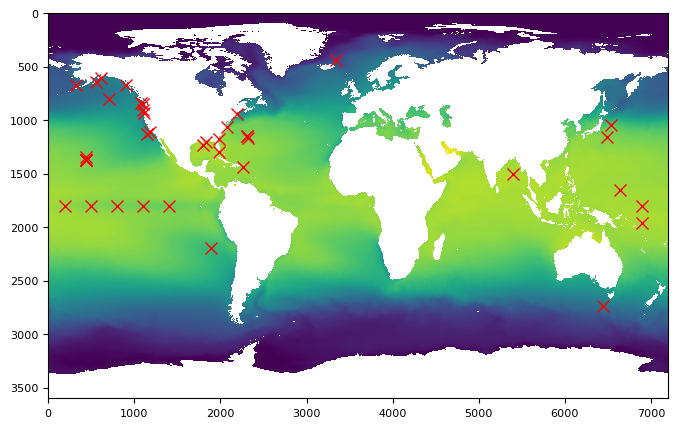

In [6]:
# obs threshold: MMM+1, use NOAA satellite climatology
ds3=xr.open_dataset('/work/ebo/calcs/extremes/MMM_NOAA/ct5km_climatology_v3.1.nc')
clo,cla=np.meshgrid(ds3.lon,ds3.lat)
out=list()
df_T_thresh['T_MMM_obs']=np.nan
for ind, row in df_T_thresh.iterrows():
    cjj,cii=cf.nearest_point(row['Lat'],row['Lon'],cla,clo,thresh=2*5*np.sqrt(2)/2)
    #print(row.Lat,row.Lon,cjj,cii)
    MMM=ds3['sst_clim_mmm'].values[0,cjj,cii]
    if np.isnan(MMM):
        MMM=np.nanmean(ds3['sst_clim_mmm'].values[0,cjj-2:cjj+3,cii-2:cii+3]) # try larger area
    df_T_thresh.loc[df_T_thresh.datasetID==row['datasetID'],['T_MMM_obs']]=MMM
    out.append([cjj,cii,MMM])

fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.pcolormesh(ds3['sst_clim_mmm'].values[0,:,:])
ax.invert_yaxis()
for row in out:
    ax.plot(row[1],row[0],'rx')
ds3.close()

In [7]:
# Model T threshold: MMM+1, use model climatology
dsm=xr.open_dataset('/work/ebo/calcs/extremes/MMM_NOAA/MMM.presentday.1975_2022.19880414.nc')
out2=list()
df_T_thresh['T_MMM_mod']=np.nan
for ind, row in df_T_thresh.iterrows():
    MMM=dsm['MMM'].values[row['jj'],row['ii']]
    df_T_thresh.loc[df_T_thresh.datasetID==row['datasetID'],['T_MMM_mod']]=MMM
    out2.append(MMM)
dsm.close()

In [8]:
def stressorcount(x,y,threshx,threshy,facx=1,facy=1):
    # set fac to -1 if stressor criteria is below threshold instead of above threshold
    ix=facx*x>facx*threshx
    iy=facy*y>facy*threshy
    ireal=~np.isnan(x)&~np.isnan(y)
    return np.sum(ix),np.sum(iy),np.sum(ix&iy),np.sum(ix|iy),np.sum(ireal)

### separate T thresholds for mod and obs, with model detrended to mean date of obs

In [9]:
def _sf(num):
    return f"{num:.1f}"
thOmL=[0.9,1.5,3,3.5] # was [2,2.5,3,3.5]
thOmAll=np.arange(0.9,4.1,.1)
# Using T=MMM+1 and omega_arag=3 thresholds, calculate stressor and multiple stressor estimates:
dfoutSaveOm=dict()
for thresh_om in thOmAll:
    #thresh_om=2
    res=[]
    for dsid in dfInfoBuoy.datasetID.unique():
        #print(dsid)
        tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
        phCcomp=bc.loadMoorComp(dsid,'omega_a_0',freq='daily',path=cpath)
        phCcomp2=bc.loadMoorComp(dsid,'omega_a_P_0',freq='daily',path=cpath)
        if len(phCcomp2.obs_val)>len(phCcomp.obs_val): # La Parguera use phos (no phosC)
            phCcomp=phCcomp2
        obs_t=pd.DataFrame(np.array([tcomp.obs_tdt, tcomp.obs_val.astype(float)]).T,
                         columns=['dtUTC','tos'])
        obs_phC=pd.DataFrame(np.array([phCcomp.obs_tdt, phCcomp.obs_val.astype(float)]).T,
                           columns=['dtUTC','om_arag'])
        obsdf=obs_t.merge(obs_phC,on='dtUTC')
        if len(obsdf)>365.25*minyears:
            thresh_T_obs=np.squeeze(df_T_thresh.loc[df_T_thresh.datasetID==dsid,['T_MMM_obs']].values[0])+1
            thresh_T_mod=np.squeeze(df_T_thresh.loc[df_T_thresh.datasetID==dsid,['T_MMM_mod']].values[0])+1
            mod_t=pd.DataFrame(np.array([tcomp.mod_tdt, tcomp.mod_target.astype(float)]).T,
                             columns=['dtUTC','tos'])
            mod_phC=pd.DataFrame(np.array([phCcomp.mod_tdt, phCcomp.mod_target.astype(float)]).T,
                               columns=['dtUTC','om_arag'])
            moddf=mod_t.merge(mod_phC,on='dtUTC')
            Nt_obs,Nom_obs,Nmix_obs,Nstress_obs,Ntot_obs=stressorcount(obsdf.tos.values.astype(float),obsdf.om_arag.values.astype(float),
                                                           thresh_T_obs,thresh_om,1,-1)
            Nt_mod,Nom_mod,Nmix_mod,Nstress_mod,Ntot_mod=stressorcount(moddf.tos.values.astype(float),moddf.om_arag.values.astype(float),
                                                           thresh_T_mod,thresh_om,1,-1)
            res.append([dsid,Nt_obs,Nom_obs,Nmix_obs,Nstress_obs,Ntot_obs,Nt_mod,Nom_mod,Nmix_mod,Nstress_mod,Ntot_mod])
    dfoutStat2=pd.DataFrame(res,columns=['datasetID','Nt_obs','Nom_obs','Nmix_obs','Nstress_obs','Ntot_obs',
                                         'Nt_mod','Nom_mod','Nmix_mod','Nstress_mod','Ntot_mod'])
    dfoutStat2['fT_obs']=dfoutStat2['Nt_obs']/dfoutStat2['Ntot_obs']
    dfoutStat2['fom_obs']=dfoutStat2['Nom_obs']/dfoutStat2['Ntot_obs']
    dfoutStat2['fmix_obs']=dfoutStat2['Nmix_obs']/dfoutStat2['Ntot_obs']
    dfoutStat2['fT_mod']=dfoutStat2['Nt_mod']/dfoutStat2['Ntot_mod']
    dfoutStat2['fom_mod']=dfoutStat2['Nom_mod']/dfoutStat2['Ntot_mod']
    dfoutStat2['fmix_mod']=dfoutStat2['Nmix_mod']/dfoutStat2['Ntot_mod']
    dfoutStat2['rmix_obs']=dfoutStat2['Nmix_obs']/dfoutStat2['Nstress_obs']
    dfoutStat2['rmix_mod']=dfoutStat2['Nmix_mod']/dfoutStat2['Nstress_mod']
    dfoutSaveOm[_sf(thresh_om)]=dfoutStat2.copy(deep=True)

In [10]:
# Using T=MMM+1 and omega_arag=3 thresholds, calculate stressor and multiple stressor estimates:
dfoutSaveT=dict()
Tsall=np.arange(-1,4,.5)
for thresh_T in Tsall:#[0,1,2,3]:
    thresh_om=3
    res=[]
    for dsid in dfInfoBuoy.datasetID.unique():
        #print(dsid)
        tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
        phCcomp=bc.loadMoorComp(dsid,'omega_a_0',freq='daily',path=cpath)
        phCcomp2=bc.loadMoorComp(dsid,'omega_a_P_0',freq='daily',path=cpath)
        if len(phCcomp2.obs_val)>len(phCcomp.obs_val): # La Parguera use phos (no phosC)
            phCcomp=phCcomp2
        obs_t=pd.DataFrame(np.array([tcomp.obs_tdt, tcomp.obs_val.astype(float)]).T,
                         columns=['dtUTC','tos'])
        obs_phC=pd.DataFrame(np.array([phCcomp.obs_tdt, phCcomp.obs_val.astype(float)]).T,
                           columns=['dtUTC','om_arag'])
        obsdf=obs_t.merge(obs_phC,on='dtUTC')
        if len(obsdf)>365.25*minyears:
            thresh_T_obs=np.squeeze(df_T_thresh.loc[df_T_thresh.datasetID==dsid,['T_MMM_obs']].values[0])+thresh_T
            thresh_T_mod=np.squeeze(df_T_thresh.loc[df_T_thresh.datasetID==dsid,['T_MMM_mod']].values[0])+thresh_T
            mod_t=pd.DataFrame(np.array([tcomp.mod_tdt, tcomp.mod_target.astype(float)]).T,
                             columns=['dtUTC','tos'])
            mod_phC=pd.DataFrame(np.array([phCcomp.mod_tdt, phCcomp.mod_target.astype(float)]).T,
                               columns=['dtUTC','om_arag'])
            moddf=mod_t.merge(mod_phC,on='dtUTC')
            Nt_obs,Nom_obs,Nmix_obs,Nstress_obs,Ntot_obs=stressorcount(obsdf.tos.values.astype(float),obsdf.om_arag.values.astype(float),
                                                           thresh_T_obs,thresh_om,1,-1)
            Nt_mod,Nom_mod,Nmix_mod,Nstress_mod,Ntot_mod=stressorcount(moddf.tos.values.astype(float),moddf.om_arag.values.astype(float),
                                                           thresh_T_mod,thresh_om,1,-1)
            res.append([dsid,Nt_obs,Nom_obs,Nmix_obs,Nstress_obs,Ntot_obs,Nt_mod,Nom_mod,Nmix_mod,Nstress_mod,Ntot_mod])
    dfoutStat2=pd.DataFrame(res,columns=['datasetID','Nt_obs','Nom_obs','Nmix_obs','Nstress_obs','Ntot_obs',
                                         'Nt_mod','Nom_mod','Nmix_mod','Nstress_mod','Ntot_mod'])
    dfoutStat2['fT_obs']=dfoutStat2['Nt_obs']/dfoutStat2['Ntot_obs']
    dfoutStat2['fom_obs']=dfoutStat2['Nom_obs']/dfoutStat2['Ntot_obs']
    dfoutStat2['fmix_obs']=dfoutStat2['Nmix_obs']/dfoutStat2['Ntot_obs']
    dfoutStat2['fT_mod']=dfoutStat2['Nt_mod']/dfoutStat2['Ntot_mod']
    dfoutStat2['fom_mod']=dfoutStat2['Nom_mod']/dfoutStat2['Ntot_mod']
    dfoutStat2['fmix_mod']=dfoutStat2['Nmix_mod']/dfoutStat2['Ntot_mod']
    dfoutStat2['rmix_obs']=dfoutStat2['Nmix_obs']/dfoutStat2['Nstress_obs']
    dfoutStat2['rmix_mod']=dfoutStat2['Nmix_mod']/dfoutStat2['Nstress_mod']
    dfoutSaveT[thresh_T]=dfoutStat2.copy(deep=True)

/nbhome/Elise.Olson/anaconda3/envs/py39dc/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


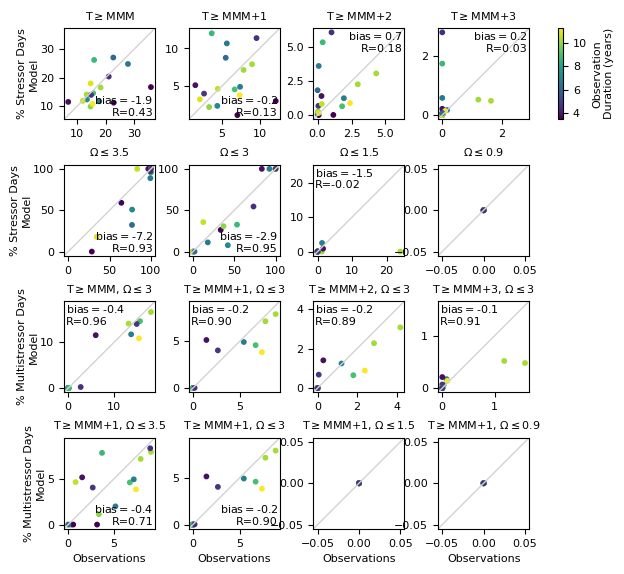

In [11]:
fig,ax=plt.subplots(4,5,figsize=(6.5,6.5),gridspec_kw={'width_ratios':[1,1,1,1,.05],'wspace':.3,'hspace':.5})
df=dfoutSaveT[0]
iax=ax[0,0]
x=df['fT_obs'].values*100
y=df['fT_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)
iax=ax[2,0]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM, $\Omega \leq$3')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.02, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='left', va='top',
         transform=iax.transAxes)

df=dfoutSaveT[1]
iax=ax[0,1]
x=df['fT_obs'].values*100
y=df['fT_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+1')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)
iax=ax[2,1]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+1, $\Omega \leq$3')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.02, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='left', va='top',
         transform=iax.transAxes)


df=dfoutSaveT[2]
iax=ax[0,2]
x=df['fT_obs'].values*100
y=df['fT_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+2')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='top',
         transform=iax.transAxes)
iax=ax[2,2]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+2, $\Omega \leq$3')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.02, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='left', va='top',
         transform=iax.transAxes)


df=dfoutSaveT[3]
iax=ax[0,3]
x=df['fT_obs'].values*100
y=df['fT_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+3')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='top',
         transform=iax.transAxes)
iax=ax[2,3]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+3, $\Omega \leq$3')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.02, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='left', va='top',
         transform=iax.transAxes)

cb=fig.colorbar(m,cax=ax[0,4])
ax[0,4].set_ylabel('Observation\nDuration (years)')

df=dfoutSaveOm[_sf(thOmL[3])]
iax=ax[1,0]
x=df['fom_obs'].values*100
y=df['fom_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('$\Omega \leq$'+f'{thOmL[3]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)
iax=ax[3,0]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+1, $\Omega \leq$'+f'{thOmL[3]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)

df=dfoutSaveOm[_sf(thOmL[2])]
iax=ax[1,1]
x=df['fom_obs'].values*100
y=df['fom_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('$\Omega \leq$'+f'{thOmL[2]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)
iax=ax[3,1]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+1, $\Omega \leq$'+f'{thOmL[2]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)


df=dfoutSaveOm[_sf(thOmL[1])]
iax=ax[1,2]
x=df['fom_obs'].values*100
y=df['fom_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('$\Omega \leq$'+f'{thOmL[1]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
iax.text(.02, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='left', va='top',
         transform=iax.transAxes)
iax=ax[3,2]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+1, $\Omega \leq$'+f'{thOmL[1]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
# iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
#          transform=iax.transAxes)


df=dfoutSaveOm[_sf(thOmL[0])]
iax=ax[1,3]
x=df['fom_obs'].values*100
y=df['fom_mod'].values*100
m=iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('$\Omega \leq$'+f'{thOmL[0]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
# iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
#          transform=iax.transAxes)
iax=ax[3,3]
x=df['fmix_obs'].values*100
y=df['fmix_mod'].values*100
iax.scatter(x,y,c=df['Ntot_obs']/365.25,s=10)
iax.set_title('T$\geq$MMM+1, $\Omega \leq$'+f'{thOmL[0]}')
R=np.corrcoef(x,y)[1,0]
bb=np.mean(y-x)
# iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
#          transform=iax.transAxes)

# for iax in ax[0,:4]:
#     iax.set_xlim(0,30)
#     iax.set_ylim(0,30)

for iax in ax[:2,0]:
    iax.set_ylabel('% Stressor Days\nModel',labelpad=1)
for iax in ax[2:,0]:
    iax.set_ylabel('% Multistressor Days\nModel',labelpad=1)
for iax in ax[3,:4]:
    iax.set_xlabel('Observations')
for iax in ax[:,:4].flatten():
    viz.squareax(iax)
for iax in ax[1:,4]:
    iax.remove()
fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesTOmSens_Rev.png',dpi=400,bbox_inches='tight')

In [12]:
dfoutSaveOm['0.9']

,datasetID,Nt_obs,Nom_obs,Nmix_obs,Nstress_obs,Ntot_obs,Nt_mod,Nom_mod,Nmix_mod,Nstress_mod,Ntot_mod,fT_obs,fom_obs,fmix_obs,fT_mod,fom_mod,fmix_mod,rmix_obs,rmix_mod
0,pmel_co2_moorings_c2e7_ecb9_4565,336,0,0,336,3727,1387,0,0,1387,17520,0.090153,0.0,0.0,0.079167,0.0,0.0,0.0,0.0
1,pmel_co2_moorings_ab27_2faf_3aa1,115,0,0,115,2601,423,0,0,423,17520,0.044214,0.0,0.0,0.024144,0.0,0.0,0.0,0.0
2,pmel_co2_moorings_cf08_f32f_712a,157,0,0,157,1293,536,0,0,536,17520,0.121423,0.0,0.0,0.030594,0.0,0.0,0.0,0.0
3,pmel_co2_moorings_3b97_8e9a_3b51,121,0,0,121,3620,397,0,0,397,17520,0.033425,0.0,0.0,0.022660,0.0,0.0,0.0,0.0
4,pmel_co2_moorings_ab03_dbac_935b,90,0,0,90,1273,209,0,0,209,17520,0.070699,0.0,0.0,0.011929,0.0,0.0,0.0,0.0
5,pmel_co2_moorings_cb2d_135a_c444,219,0,0,219,3263,805,0,0,805,17520,0.067116,0.0,0.0,0.045947,0.0,0.0,0.0,0.0
6,pmel_co2_moorings_9675_b3d3_c1c1,293,0,0,293,3712,1254,0,0,1254,17520,0.078933,0.0,0.0,0.071575,0.0,0.0,0.0,0.0
7,pmel_co2_moorings_299e_e649_3487,184,0,0,184,2477,864,0,0,864,17520,0.074283,0.0,0.0,0.049315,0.0,0.0,0.0,0.0
8,pmel_co2_moorings_fad6_8193_8d89,21,0,0,21,1384,902,0,0,902,17520,0.015173,0.0,0.0,0.051484,0.0,0.0,0.0,0.0
9,pmel_co2_moorings_cba8_5413_09f9,303,0,0,303,4102,673,0,0,673,17520,0.073866,0.0,0.0,0.038413,0.0,0.0,0.0,0.0


In [13]:
data=[]
for om in thOmAll:
    df=dfoutSaveOm[_sf(om)]
    xs=df['fom_obs'].values*100
    ys=df['fom_mod'].values*100
    xmix=df['fmix_obs'].values*100
    ymix=df['fmix_mod'].values*100
    Rs=np.corrcoef(xs,ys)[1,0]
    bs=np.mean((ys-xs)*2/(ys+xs))
    Rmix=np.corrcoef(xmix,ymix)[1,0]
    bmix=np.mean((ymix-xmix)*2/(ymix+xmix))
    data.append([om,Rs,bs,Rmix,bmix])
dfs=pd.DataFrame(data,columns=['om','Rs','bs','Rmix','bmix'])

/nbhome/Elise.Olson/anaconda3/envs/py39dc/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/tmp/ipykernel_19811/1364830779.py:9: RuntimeWarning: invalid value encountered in divide
  bs=np.mean((ys-xs)*2/(ys+xs))
/tmp/ipykernel_19811/1364830779.py:11: RuntimeWarning: invalid value encountered in divide
  bmix=np.mean((ymix-xmix)*2/(ymix+xmix))
/nbhome/Elise.Olson/anaconda3/envs/py39dc/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


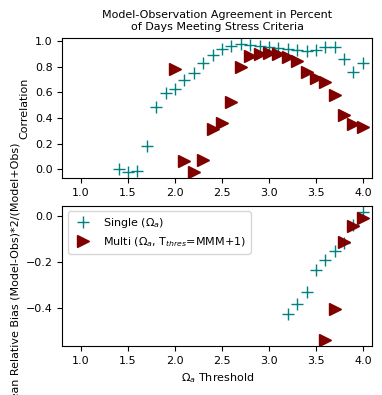

In [14]:
fig,ax=plt.subplots(2,1,figsize=(4,4))
ax[0].plot(dfs.om,dfs.Rs,'+',color='teal')
ax[0].plot(dfs.om,dfs.Rmix,'>',color='maroon')
ax[1].plot(dfs.om,dfs.bs,'+',color='teal',label='Single ($\Omega _a$)')
ax[1].plot(dfs.om,dfs.bmix,'>',color='maroon',label='Multi ($\Omega _a$, T$_{thres}$=MMM+1)')
ax[0].set_xlim(0.8,4.1)
ax[1].set_xlim(0.8,4.1)
ax[1].set_xlabel('$\Omega _a$ Threshold')
ax[0].set_ylabel('Correlation')
ax[1].set_ylabel('Mean Relative Bias (Model-Obs)*2/(Model+Obs)')
ax[0].set_title('Model-Observation Agreement in Percent\nof Days Meeting Stress Criteria')
ax[1].legend()

In [15]:
dfs

,om,Rs,bs,Rmix,bmix
0,0.9,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN
2,1.1,NaN,NaN,NaN,NaN
3,1.2,NaN,NaN,NaN,NaN
4,1.3,NaN,NaN,NaN,NaN
5,1.4,0.001199,NaN,NaN,NaN
6,1.5,-0.016422,NaN,NaN,NaN
7,1.6,-0.010117,NaN,NaN,NaN
8,1.7,0.184422,NaN,NaN,NaN
9,1.8,0.487081,NaN,NaN,NaN
